# Imports

In [1]:
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

# Configs

In [2]:
BASE_PATH = "/Users/maedeh/Desktop/demand_project/demand_project/shoofer-demand-prediction/data/"

LABELED_PATH = BASE_PATH + "labels_phase2.parquet"
XGB_MODEL_PATH = BASE_PATH + "XGB_predictions_phase2.parquet"
RIDGE_MODEL_PATH = BASE_PATH + "Ridge_predictions_phase2.parquet"
RF_RIDGE_MODEL_PATH = BASE_PATH + "RF_ridge_predictions_phase2.parquet"

SAVE_PLOT_PATH = BASE_PATH + 'pngs/'



MODEL_LIST = ['BASELINE_LAST_WEEK', 'RIDGE_MODEL', 'XGB_MODEL', 'RF_RIDGE_MODEL']
CATEGORIES = ['high_demand_locations', 'mid_demand_locations', 'low_demand_locations', 'all_locations']
METRICS = ['MAPE', 'MAE', 'RMSE']
BASED_ON = ['Location', 'Date', 'Hour_interval', 'Day_of_week']


TEST_START_DATE = '2023-04-01'
LAST_WEEK_TEST_START_DATE = '2023-03-25'


NUM_INTERVAL_PER_DAY = 8
HIGH_DEMAND_NUMS = 55
MID_DEMAND_NUMS = 157
NUM_LOC = 262
SORT_METHOD = 'mean'



warnings.filterwarnings('ignore')

In [3]:
report_dict = {cat:{met:{model:None for model in MODEL_LIST} for met in METRICS} for cat in CATEGORIES}
predictions_dict = {model:None for model in MODEL_LIST}
sorted_locations_dict={cat:None for cat in CATEGORIES}
predictions_mean_error_dict={model:{based:{cat:None for cat in CATEGORIES} for based in BASED_ON} for model in MODEL_LIST}

# Load Data

## Load labeled data

In [4]:
labeled_df = pd.read_parquet(LABELED_PATH)
print(labeled_df.shape)
labeled_df.head()

(251520, 4)


,Location,Date,Hour_interval,Demand
0,1,2023-01-01,0,0.0
1,1,2023-01-01,3,1.0
2,1,2023-01-01,6,1.0
3,1,2023-01-01,9,1.0
4,1,2023-01-01,12,13.0


In [5]:
test_df = labeled_df.loc[labeled_df['Date']>=TEST_START_DATE]
test_df = test_df.reset_index(drop = True)
print(test_df.shape)
test_df.head()

(62880, 4)


,Location,Date,Hour_interval,Demand
0,1,2023-04-01,0,0.0
1,1,2023-04-01,3,1.0
2,1,2023-04-01,6,1.0
3,1,2023-04-01,9,0.0
4,1,2023-04-01,12,1.0


## Load Predicted Data

In [6]:
for model in MODEL_LIST:
    if model != 'BASELINE_LAST_WEEK':
        predictions_dict[model] = pd.read_parquet(eval(model + '_PATH'))
        print(f"shape of {model} {predictions_dict[model].shape}")
        display(predictions_dict[model].head())

shape of RIDGE_MODEL (62880, 4)


,Location,Date,Hour_interval,Predicted_demand
0,1,2023-04-01,0,1.011298
1,1,2023-04-01,3,1.565223
2,1,2023-04-01,6,4.352847
3,1,2023-04-01,9,2.877746
4,1,2023-04-01,12,4.282441


shape of XGB_MODEL (62880, 4)


,Location,Date,Hour_interval,Predicted_demand
0,1,2023-04-01,0,0.059216
1,1,2023-04-01,3,0.400379
2,1,2023-04-01,6,1.639149
3,1,2023-04-01,9,1.369392
4,1,2023-04-01,12,2.594998


shape of RF_RIDGE_MODEL (62880, 4)


,Location,Date,Hour_interval,Predicted_demand
0,1,2023-04-01,0,0.000833
1,1,2023-04-01,3,0.346463
2,1,2023-04-01,6,1.822064
3,1,2023-04-01,9,1.437866
4,1,2023-04-01,12,2.638232


### BaseLine Models

In [7]:
def baseline_predict(dataset, shift_val):
    baseline_test_df = dataset.loc[dataset['Date']>=LAST_WEEK_TEST_START_DATE]
    baseline_test_df = baseline_test_df.reset_index(drop = True)
    predicted_demand = baseline_test_df.groupby(['Location'])['Demand'].shift(shift_val)
    predicted_data = pd.DataFrame(baseline_test_df[['Location', 'Date', 'Hour_interval']])
    predicted_data['Predicted_demand'] = predicted_demand
    predicted_data = predicted_data.dropna()
    return predicted_data

In [8]:
predictions_dict['BASELINE_LAST_WEEK'] = baseline_predict(labeled_df, 7*NUM_INTERVAL_PER_DAY)
print(predictions_dict['BASELINE_LAST_WEEK'].shape)
predictions_dict['BASELINE_LAST_WEEK'].head()

(62880, 4)


,Location,Date,Hour_interval,Predicted_demand
56,1,2023-04-01,0,0.0
57,1,2023-04-01,3,0.0
58,1,2023-04-01,6,3.0
59,1,2023-04-01,9,2.0
60,1,2023-04-01,12,3.0


### Join Predictions and Actual

In [9]:
def join_actual_predict(actual_df, predicted_df):
    for label,predictions_df in predicted_df.items():
        if (predictions_df is not None):
            actual_predicted_df = actual_df.merge(predictions_df, how='left', on=['Location', 'Date', 'Hour_interval'])
            actual_predicted_df['Date'] = pd.to_datetime(actual_predicted_df['Date'])
            actual_predicted_df['Day_of_week'] = actual_predicted_df['Date'].dt.dayofweek
            predictions_dict[label] = actual_predicted_df

In [10]:
join_actual_predict(test_df,predictions_dict)
for model in MODEL_LIST:
    print(f"shape of predictions_dict[{model}]: {predictions_dict[model].shape}")
    display(predictions_dict[model].head())

shape of predictions_dict[BASELINE_LAST_WEEK]: (62880, 6)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,0,0.0,0.0,5
1,1,2023-04-01,3,1.0,0.0,5
2,1,2023-04-01,6,1.0,3.0,5
3,1,2023-04-01,9,0.0,2.0,5
4,1,2023-04-01,12,1.0,3.0,5


shape of predictions_dict[RIDGE_MODEL]: (62880, 6)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,0,0.0,1.011298,5
1,1,2023-04-01,3,1.0,1.565223,5
2,1,2023-04-01,6,1.0,4.352847,5
3,1,2023-04-01,9,0.0,2.877746,5
4,1,2023-04-01,12,1.0,4.282441,5


shape of predictions_dict[XGB_MODEL]: (62880, 6)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,0,0.0,0.059216,5
1,1,2023-04-01,3,1.0,0.400379,5
2,1,2023-04-01,6,1.0,1.639149,5
3,1,2023-04-01,9,0.0,1.369392,5
4,1,2023-04-01,12,1.0,2.594998,5


shape of predictions_dict[RF_RIDGE_MODEL]: (62880, 6)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week
0,1,2023-04-01,0,0.0,0.000833,5
1,1,2023-04-01,3,1.0,0.346463,5
2,1,2023-04-01,6,1.0,1.822064,5
3,1,2023-04-01,9,0.0,1.437866,5
4,1,2023-04-01,12,1.0,2.638232,5


### Sort Locations by Demand

In [11]:
def sort_locations_on_demand(predictions_dict,sorted_locations_dict):
    predictions_df = predictions_dict['BASELINE_LAST_WEEK']
    if (predictions_df is not None):
        sorted_index = predictions_df.groupby(['Location','Hour_interval'])['Demand'].aggregate([SORT_METHOD]).sort_values(SORT_METHOD, ascending=False)
        sorted_index = sorted_index.reset_index()
        sorted_locations_dict['high_demand_locations'] = sorted_index[:HIGH_DEMAND_NUMS]
        sorted_locations_dict['mid_demand_locations'] = sorted_index[HIGH_DEMAND_NUMS:MID_DEMAND_NUMS+HIGH_DEMAND_NUMS]
        sorted_locations_dict['low_demand_locations'] = sorted_index[MID_DEMAND_NUMS+HIGH_DEMAND_NUMS:]
        sorted_locations_dict['all_locations'] = sorted_index
        

In [12]:
sort_locations_on_demand(predictions_dict, sorted_locations_dict)
for cat in CATEGORIES:
    print(f"shape of sorted_locations_dict[{cat}]: {sorted_locations_dict[cat].shape}")
    display(sorted_locations_dict[cat].head())

shape of sorted_locations_dict[high_demand_locations]: (55, 3)


,Location,Hour_interval,mean
0,161,15,1188.933333
1,132,15,1169.400000
2,132,21,1152.500000
3,237,15,1147.266667
4,161,18,1104.666667


shape of sorted_locations_dict[mid_demand_locations]: (157, 3)


,Location,Hour_interval,mean
55,132,6,542.600000
56,48,18,530.233333
57,170,9,528.000000
58,68,15,521.900000
59,43,15,517.500000


shape of sorted_locations_dict[low_demand_locations]: (1884, 3)


,Location,Hour_interval,mean
212,186,0,165.033333
213,137,9,162.833333
214,90,0,160.033333
215,137,21,158.500000
216,158,15,156.866667


shape of sorted_locations_dict[all_locations]: (2096, 3)


,Location,Hour_interval,mean
0,161,15,1188.933333
1,132,15,1169.400000
2,132,21,1152.500000
3,237,15,1147.266667
4,161,18,1104.666667


# Mean error Calculation

### Error Columns

In [13]:
def calculate_error(actual_predicted_dict: dict):
    for label,actual_predicted_df in actual_predicted_dict.items():
        if (actual_predicted_df is not None):
            
            actual_predicted_df['error'] = np.abs(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            
            actual_predicted_df['squared_error'] = np.square(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            
            actual_Demand_df = np.where(actual_predicted_df['Demand']==0, 1, actual_predicted_df['Demand'])
            # actual_Demand_df = actual_predicted_df['Demand']+1
            actual_predicted_df['percentage_error'] = (
                actual_predicted_df['error']/actual_Demand_df
                )*100
            

In [14]:
calculate_error(predictions_dict)
for model in MODEL_LIST:
    print(f"shape of predictions_dict[{model}]: {predictions_dict[model].shape}")
    display(predictions_dict[model].head())

shape of predictions_dict[BASELINE_LAST_WEEK]: (62880, 9)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,0,0.0,0.0,5,0.0,0.0,0.0
1,1,2023-04-01,3,1.0,0.0,5,1.0,1.0,100.0
2,1,2023-04-01,6,1.0,3.0,5,2.0,4.0,200.0
3,1,2023-04-01,9,0.0,2.0,5,2.0,4.0,200.0
4,1,2023-04-01,12,1.0,3.0,5,2.0,4.0,200.0


shape of predictions_dict[RIDGE_MODEL]: (62880, 9)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,0,0.0,1.011298,5,1.011298,1.022723,101.129770
1,1,2023-04-01,3,1.0,1.565223,5,0.565223,0.319477,56.522330
2,1,2023-04-01,6,1.0,4.352847,5,3.352847,11.241584,335.284715
3,1,2023-04-01,9,0.0,2.877746,5,2.877746,8.281422,287.774596
4,1,2023-04-01,12,1.0,4.282441,5,3.282441,10.774419,328.244096


shape of predictions_dict[XGB_MODEL]: (62880, 9)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,0,0.0,0.059216,5,0.059216,0.003507,5.921597
1,1,2023-04-01,3,1.0,0.400379,5,0.599621,0.359545,59.962088
2,1,2023-04-01,6,1.0,1.639149,5,0.639149,0.408511,63.914871
3,1,2023-04-01,9,0.0,1.369392,5,1.369392,1.875234,136.939192
4,1,2023-04-01,12,1.0,2.594998,5,1.594998,2.544018,159.499788


shape of predictions_dict[RF_RIDGE_MODEL]: (62880, 9)


,Location,Date,Hour_interval,Demand,Predicted_demand,Day_of_week,error,squared_error,percentage_error
0,1,2023-04-01,0,0.0,0.000833,5,0.000833,6.944444e-07,0.083333
1,1,2023-04-01,3,1.0,0.346463,5,0.653537,4.271111e-01,65.353735
2,1,2023-04-01,6,1.0,1.822064,5,0.822064,6.757899e-01,82.206441
3,1,2023-04-01,9,0.0,1.437866,5,1.437866,2.067458e+00,143.786579
4,1,2023-04-01,12,1.0,2.638232,5,1.638232,2.683804e+00,163.823201


### Aggregate Error Columns

In [15]:
def calculate_mean_error(actual_predicted_dict: dict, predictions_mean_dict: dict):
    for model,actual_predicted_df in actual_predicted_dict.items():
        if (actual_predicted_df is not None):
            for cat in CATEGORIES:
                sorted_locations = sorted_locations_dict[cat]
                categorized_df = actual_predicted_df.merge(sorted_locations[['Location', 'Hour_interval']], on=['Location','Hour_interval'])
                for per in BASED_ON:
                    categorized_error_df = categorized_df[[per,'Demand','error','squared_error', 'percentage_error']]
                    categorized_mean_df = (
                        categorized_error_df.groupby(per).agg(mape=('percentage_error','mean'),
                                                              mae=('error','mean'),
                                                              mse=('squared_error','mean'),
                                                              demand_mean=('Demand','mean'))
                                                              ) 
                    categorized_mean_df['rmse'] = np.sqrt(categorized_mean_df['mse'])
                    categorized_mean_df.drop(columns='mse', inplace=True)
                    categorized_mean_df['mape'] = np.where(categorized_mean_df['mape']>100, 100, categorized_mean_df['mape'])
                    if per == 'Location':
                        loc_demand_index = sorted_locations.groupby(['Location'])[SORT_METHOD].sum().sort_values(ascending=False).index
                        categorized_mean_df = categorized_mean_df.reindex(loc_demand_index)
                    if per == 'Hour_interval':
                        hour_demand_index = sorted_locations.groupby(['Hour_interval'])[SORT_METHOD].sum().sort_values(ascending=False).index
                        categorized_mean_df = categorized_mean_df.reindex(hour_demand_index)
            
                    predictions_mean_dict[model][per][cat] = categorized_mean_df.reset_index()
                        


In [26]:
calculate_mean_error(predictions_dict, predictions_mean_error_dict)
for model in MODEL_LIST:
    for per in BASED_ON:
        for cat in CATEGORIES:
            print(f"shape of predictions_mean_dict[{model}][{per}][{cat}]: {predictions_mean_error_dict[model][per][cat].shape}")
            display(predictions_mean_error_dict[model][per][cat].head())

shape of predictions_mean_dict[BASELINE_LAST_WEEK][Location][high_demand_locations]: (17, 5)


,Location,mape,mae,demand_mean,rmse
0,237,11.066805,95.553333,932.306667,119.404718
1,161,9.794555,81.786667,921.106667,103.689987
2,132,11.858162,119.566667,1055.683333,159.241379
3,236,12.494361,114.508333,933.408333,137.019372
4,138,17.149296,104.226667,691.960000,128.405400


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Location][mid_demand_locations]: (40, 5)


,Location,mape,mae,demand_mean,rmse
0,141,11.916259,46.405556,411.172222,58.542530
1,164,13.785970,47.961111,387.805556,64.375418
2,107,13.647393,44.009524,328.009524,62.723733
3,48,9.810533,37.900000,371.744444,52.441926
4,68,10.767214,35.961111,354.450000,47.528062


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Location][low_demand_locations]: (262, 5)


,Location,mape,mae,demand_mean,rmse
0,50,26.767634,20.370833,91.575000,31.773744
1,75,23.448993,14.608333,78.408333,20.526812
2,13,30.869464,11.566667,75.358333,16.834241
3,158,25.665826,18.655556,96.572222,33.541185
4,261,36.208594,13.995833,70.125000,20.073926


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Location][all_locations]: (262, 5)


,Location,mape,mae,demand_mean,rmse
0,132,18.087126,96.437500,722.312500,134.945437
1,237,16.621162,70.704167,640.745833,99.491478
2,161,14.992237,58.808333,621.241667,83.844549
3,236,19.444128,77.600000,576.316667,109.358889
4,142,19.899866,64.316667,472.700000,93.465368


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,11.339361,82.127273,713.490909,105.628078
1,2023-04-02,10.571272,64.036364,643.763636,81.923911
2,2023-04-03,13.557941,92.581818,696.981818,123.638035
3,2023-04-04,9.163401,70.563636,784.163636,92.718440
4,2023-04-05,15.153898,114.600000,815.672727,133.535355


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Date][mid_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,12.348724,44.808917,353.312102,63.061945
1,2023-04-02,11.602200,30.872611,277.828025,45.244347
2,2023-04-03,14.500221,39.267516,281.286624,52.111529
3,2023-04-04,11.843242,35.261146,318.210191,48.309775
4,2023-04-05,15.293254,52.694268,342.598726,71.519673


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,38.693496,2.622611,11.830679,7.608905
1,2023-04-02,38.170721,2.501592,11.066879,8.176691
2,2023-04-03,46.028048,1.985669,7.653397,5.439251
3,2023-04-04,46.988872,2.119958,8.227707,6.292414
4,2023-04-05,48.075542,2.526539,9.023355,7.973283


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Date][all_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,36.002366,7.868798,55.821088,25.351395
1,2023-04-02,35.456395,6.241412,47.650763,19.736842
2,2023-04-03,42.814439,7.155534,46.238073,25.122220
3,2023-04-04,43.363746,6.398378,51.807729,20.880282
4,2023-04-05,44.756120,9.225191,55.176527,30.136300


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Hour_interval][high_demand_locations]: (6, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,18,13.485814,99.457143,763.947619,126.550404
1,15,10.100434,79.110256,822.312821,102.791512
2,12,9.251582,66.958333,737.800000,85.664478
3,21,16.377035,106.037037,723.918519,139.941999
4,9,10.333792,69.655556,688.577778,87.168674


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Hour_interval][mid_demand_locations]: (7, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,9,10.384432,33.778571,332.419048,45.969244
1,15,13.322211,41.176923,323.225641,55.286526
2,18,16.267815,51.164000,330.929333,67.481188
3,12,10.773490,34.123611,330.745833,46.587895
4,21,17.894838,56.086111,323.804167,78.852975


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Hour_interval][low_demand_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,0,35.151259,3.985657,13.095883,14.641098
1,6,51.617125,2.747107,11.446006,7.315857
2,12,55.994037,2.352360,9.773894,6.031860
3,21,40.224833,2.639738,9.192576,8.734237
4,3,39.816588,2.280789,7.862341,7.583102


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Hour_interval][all_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,15,43.474773,9.904707,80.125827,29.319172
1,18,40.877484,12.245293,79.184097,36.579604
2,12,49.710821,8.221756,72.520611,23.797318
3,21,37.360138,11.087405,62.563613,36.179713
4,9,50.864129,7.244529,58.895674,20.857898


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,12.162811,83.395455,706.463636,109.792552
1,1,9.049524,71.822727,813.959091,91.878650
2,2,10.270257,82.281818,842.154545,105.309587
3,3,11.323170,91.386364,849.177273,118.631458
4,4,12.234017,95.645455,793.772727,127.906784


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Day_of_week][mid_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,13.448909,35.133758,274.810510,49.000357
1,1,11.818564,35.756369,319.777070,48.973069
2,2,13.740587,43.949045,340.643312,61.310139
3,3,12.901209,44.506369,349.041401,61.402400
4,4,13.668541,45.079618,345.729299,62.043980


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,47.084297,2.134023,7.494427,6.441823
1,1,48.680646,2.126460,8.159899,6.434063
2,2,47.681283,2.382696,8.965234,7.311158
3,3,49.654844,2.639995,9.862792,7.837988
4,4,48.951726,2.728636,10.399682,7.800925


shape of predictions_mean_dict[BASELINE_LAST_WEEK][Day_of_week][all_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,43.648496,6.738192,45.858898,23.096785
1,1,44.879568,6.474356,52.645992,20.937336
2,2,44.157287,7.592796,55.672710,24.912193
3,3,45.895988,8.104723,57.292820,26.588018
4,4,45.345365,8.339098,56.073473,27.790985


shape of predictions_mean_dict[RIDGE_MODEL][Location][high_demand_locations]: (17, 5)


,Location,mape,mae,demand_mean,rmse
0,237,8.978837,75.912311,932.306667,96.725790
1,161,9.066703,67.924717,921.106667,85.426232
2,132,9.036190,92.751383,1055.683333,121.156828
3,236,9.014928,83.412993,933.408333,106.419237
4,138,15.442542,90.116278,691.960000,111.048980


shape of predictions_mean_dict[RIDGE_MODEL][Location][mid_demand_locations]: (40, 5)


,Location,mape,mae,demand_mean,rmse
0,141,9.968662,37.198005,411.172222,46.926678
1,164,13.708967,38.677707,387.805556,51.952721
2,107,13.889861,35.235488,328.009524,47.495766
3,48,9.967518,33.386162,371.744444,43.328142
4,68,11.320833,31.932734,354.450000,40.494300


shape of predictions_mean_dict[RIDGE_MODEL][Location][low_demand_locations]: (262, 5)


,Location,mape,mae,demand_mean,rmse
0,50,27.115859,18.249087,91.575000,26.739465
1,75,19.339771,11.153851,78.408333,15.670445
2,13,28.165101,9.948496,75.358333,14.478487
3,158,39.014530,16.624963,96.572222,24.956270
4,261,29.859376,11.754066,70.125000,16.792764


shape of predictions_mean_dict[RIDGE_MODEL][Location][all_locations]: (262, 5)


,Location,mape,mae,demand_mean,rmse
0,132,12.626653,72.048338,722.312500,99.464697
1,237,14.604009,56.569360,640.745833,80.015989
2,161,14.338147,49.323926,621.241667,69.207448
3,236,16.028304,58.899289,576.316667,85.659045
4,142,16.321218,49.827937,472.700000,74.239100


shape of predictions_mean_dict[RIDGE_MODEL][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,9.031163,63.264064,713.490909,75.502389
1,2023-04-02,9.334831,54.336957,643.763636,67.828879
2,2023-04-03,13.014795,73.348917,696.981818,91.536354
3,2023-04-04,8.177449,60.559171,784.163636,79.957712
4,2023-04-05,14.824062,105.890705,815.672727,127.459824


shape of predictions_mean_dict[RIDGE_MODEL][Date][mid_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,9.259385,32.708898,353.312102,44.267530
1,2023-04-02,13.646950,32.774949,277.828025,44.672926
2,2023-04-03,16.943100,33.231497,281.286624,44.718986
3,2023-04-04,10.413464,30.572041,318.210191,41.018610
4,2023-04-05,14.900652,49.144250,342.598726,65.977609


shape of predictions_mean_dict[RIDGE_MODEL][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,80.022468,2.877321,11.830679,7.147598
1,2023-04-02,73.831226,2.520254,11.066879,7.141339
2,2023-04-03,90.131740,2.534368,7.653397,5.951257
3,2023-04-04,77.243560,2.109405,8.227707,5.000865
4,2023-04-05,74.413091,2.592671,9.023355,7.570904


shape of predictions_mean_dict[RIDGE_MODEL][Date][all_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,72.859145,6.696418,55.821088,18.501123
1,2023-04-02,67.630733,6.146164,47.650763,17.777831
2,2023-04-03,82.625992,6.691929,46.238073,20.037333
3,2023-04-04,70.425354,5.775136,51.807729,17.783968
4,2023-04-05,68.391693,8.790185,55.176527,28.352897


shape of predictions_mean_dict[RIDGE_MODEL][Hour_interval][high_demand_locations]: (6, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,18,10.711950,76.103301,763.947619,95.563186
1,15,8.670877,67.696917,822.312821,87.774543
2,12,7.558544,54.345549,737.800000,69.403521
3,21,14.921736,88.357714,723.918519,117.435146
4,9,7.628194,50.413370,688.577778,65.826370


shape of predictions_mean_dict[RIDGE_MODEL][Hour_interval][mid_demand_locations]: (7, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,9,8.153500,26.210932,332.419048,35.309125
1,15,11.083016,34.236607,323.225641,45.788211
2,18,12.116097,36.583789,330.929333,47.958026
3,12,9.187241,28.927114,330.745833,39.481533
4,21,15.207529,44.824001,323.804167,61.730043


shape of predictions_mean_dict[RIDGE_MODEL][Hour_interval][low_demand_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,0,55.173744,3.686953,13.095883,11.389759
1,6,59.958263,2.494828,11.446006,6.082830
2,12,63.464407,2.169690,9.773894,5.184144
3,21,55.425414,2.378474,9.192576,7.069824
4,3,56.671353,2.181070,7.862341,6.091050


shape of predictions_mean_dict[RIDGE_MODEL][Hour_interval][all_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,15,52.149647,8.527820,80.125827,24.779503
1,18,51.886328,9.323701,79.184097,27.079534
2,12,55.931879,7.010486,72.520611,19.661934
3,21,50.349985,9.220099,62.563613,29.436142
4,9,56.467128,5.816300,58.895674,16.048628


shape of predictions_mean_dict[RIDGE_MODEL][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,12.224454,71.122419,706.463636,89.340396
1,1,7.503992,53.214034,813.959091,70.693351
2,2,8.883552,66.828225,842.154545,87.728308
3,3,9.547157,76.436316,849.177273,98.504885
4,4,9.025562,68.853293,793.772727,93.963403


shape of predictions_mean_dict[RIDGE_MODEL][Day_of_week][mid_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,14.973603,29.584583,274.810510,40.637316
1,1,10.068312,26.970974,319.777070,36.676062
2,2,11.475833,34.677875,340.643312,48.048915
3,3,11.049935,37.400508,349.041401,50.176495
4,4,11.119464,35.622371,345.729299,48.045879


shape of predictions_mean_dict[RIDGE_MODEL][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,63.628420,2.292906,7.494427,6.204684
1,1,59.956053,1.957826,8.159899,4.933061
2,2,58.611401,2.210343,8.965234,6.138631
3,3,57.448524,2.416552,9.862792,6.790494
4,4,56.284222,2.454529,10.399682,6.490002


shape of predictions_mean_dict[RIDGE_MODEL][Day_of_week][all_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,58.635088,6.143296,45.858898,19.176669
1,1,54.842867,5.176412,52.645992,15.930109
2,2,53.775850,6.337913,55.672710,20.217733
3,3,52.716103,6.979323,57.292820,22.014756
4,4,51.661086,6.681286,56.073473,21.034502


shape of predictions_mean_dict[XGB_MODEL][Location][high_demand_locations]: (17, 5)


,Location,mape,mae,demand_mean,rmse
0,237,8.934733,75.517656,932.306667,93.664838
1,161,7.886981,60.578038,921.106667,78.591713
2,132,9.494983,96.193339,1055.683333,125.121961
3,236,8.877938,82.085882,933.408333,101.207432
4,138,14.837295,85.968672,691.960000,104.064420


shape of predictions_mean_dict[XGB_MODEL][Location][mid_demand_locations]: (40, 5)


,Location,mape,mae,demand_mean,rmse
0,141,9.343710,34.345215,411.172222,42.693914
1,164,12.318545,36.388038,387.805556,48.576361
2,107,11.105199,32.135729,328.009524,43.323404
3,48,8.961080,29.367565,371.744444,38.014169
4,68,9.438214,28.282733,354.450000,35.174086


shape of predictions_mean_dict[XGB_MODEL][Location][low_demand_locations]: (262, 5)


,Location,mape,mae,demand_mean,rmse
0,50,22.422587,16.034810,91.575000,23.551043
1,75,18.277810,10.736573,78.408333,14.966677
2,13,29.544535,9.518378,75.358333,13.445980
3,158,22.666219,12.867829,96.572222,19.302448
4,261,27.532997,10.252281,70.125000,14.822104


shape of predictions_mean_dict[XGB_MODEL][Location][all_locations]: (262, 5)


,Location,mape,mae,demand_mean,rmse
0,132,12.928888,73.224384,722.312500,101.101976
1,237,12.539319,55.632389,640.745833,77.726225
2,161,12.963811,43.940760,621.241667,63.578656
3,236,13.665726,56.728708,576.316667,81.310649
4,142,14.499207,49.082207,472.700000,73.330616


shape of predictions_mean_dict[XGB_MODEL][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,7.793637,54.127410,713.490909,66.009673
1,2023-04-02,7.668155,46.351041,643.763636,58.808857
2,2023-04-03,11.204633,70.124547,696.981818,89.665146
3,2023-04-04,6.793935,49.248781,784.163636,65.182849
4,2023-04-05,13.213962,93.975568,815.672727,116.165167


shape of predictions_mean_dict[XGB_MODEL][Date][mid_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,7.480812,26.815547,353.312102,37.485145
1,2023-04-02,11.442245,27.411667,277.828025,39.035968
2,2023-04-03,11.206240,28.070703,281.286624,38.366245
3,2023-04-04,9.085663,27.033298,318.210191,37.759769
4,2023-04-05,13.054601,44.196695,342.598726,60.654791


shape of predictions_mean_dict[XGB_MODEL][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,37.661048,2.195396,11.830679,6.328172
1,2023-04-02,37.732175,1.794827,11.066879,5.192066
2,2023-04-03,42.309980,1.699071,7.653397,4.535147
3,2023-04-04,38.126641,1.614786,8.227707,4.429427
4,2023-04-05,38.861170,2.074982,9.023355,6.887721


shape of predictions_mean_dict[XGB_MODEL][Date][all_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,34.616676,5.402278,55.821088,15.986976
1,2023-04-02,34.974045,4.882822,47.650763,15.136815
2,2023-04-03,39.163948,5.469942,46.238073,18.431318
3,2023-04-04,35.129154,4.768687,51.807729,15.359847
4,2023-04-05,36.255145,7.641605,55.176527,25.929025


shape of predictions_mean_dict[XGB_MODEL][Hour_interval][high_demand_locations]: (6, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,18,9.788670,69.475899,763.947619,89.053982
1,15,8.569796,66.084218,822.312821,84.518119
2,12,7.666189,54.936802,737.800000,67.846339
3,21,13.642006,84.026265,723.918519,113.193216
4,9,7.463263,49.026838,688.577778,62.620068


shape of predictions_mean_dict[XGB_MODEL][Hour_interval][mid_demand_locations]: (7, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,9,8.005656,25.682406,332.419048,34.002139
1,15,10.637608,32.261511,323.225641,43.230712
2,18,11.808365,35.085720,330.929333,44.854509
3,12,8.601329,27.206731,330.745833,37.149128
4,21,13.799224,40.295002,323.804167,54.798849


shape of predictions_mean_dict[XGB_MODEL][Hour_interval][low_demand_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,0,32.502889,2.630512,13.095883,8.914077
1,6,43.670622,2.256134,11.446006,5.781981
2,12,45.117126,1.845170,9.773894,4.653734
3,21,35.107269,2.029160,9.192576,6.572851
4,3,36.391835,1.588072,7.862341,4.628216


shape of predictions_mean_dict[XGB_MODEL][Hour_interval][all_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,15,35.654308,7.967043,80.125827,23.650554
1,18,34.652143,8.541166,79.184097,25.235424
2,12,40.056857,6.600045,72.520611,18.866084
3,21,32.418031,8.351122,62.563613,27.440262
4,9,40.666543,5.469668,58.895674,15.319705


shape of predictions_mean_dict[XGB_MODEL][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,11.172289,72.005127,706.463636,90.625339
1,1,6.818028,53.292927,813.959091,69.237787
2,2,7.834457,60.463191,842.154545,78.632315
3,3,8.596352,70.888791,849.177273,92.901182
4,4,9.017244,70.127310,793.772727,95.131250


shape of predictions_mean_dict[XGB_MODEL][Day_of_week][mid_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,12.936548,29.959715,274.810510,40.340869
1,1,8.607564,24.765765,319.777070,33.797499
2,2,9.585303,30.436155,340.643312,43.108298
3,3,9.911544,34.023337,349.041401,45.890661
4,4,10.864195,34.670697,345.729299,45.910193


shape of predictions_mean_dict[XGB_MODEL][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,42.046028,1.852673,7.494427,5.249398
1,1,39.616650,1.618874,8.159899,4.654877
2,2,39.620710,1.781490,8.965234,5.225738
3,3,39.698830,2.041198,9.862792,6.135535
4,4,39.208743,2.146192,10.399682,6.085732


shape of predictions_mean_dict[XGB_MODEL][Day_of_week][all_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,39.055454,5.798852,45.858898,19.031008
1,1,36.433276,4.708633,52.645992,15.193123
2,2,36.536834,5.467690,55.672710,18.055169
3,3,36.651483,6.243399,57.292820,20.446378
4,4,36.293368,6.366282,56.073473,20.703741


shape of predictions_mean_dict[RF_RIDGE_MODEL][Location][high_demand_locations]: (17, 5)


,Location,mape,mae,demand_mean,rmse
0,237,9.109163,75.239112,932.306667,93.891090
1,161,8.119820,61.874304,921.106667,80.513022
2,132,9.103008,91.703389,1055.683333,121.090759
3,236,8.811447,81.279087,933.408333,100.892896
4,138,15.317900,89.384671,691.960000,109.274848


shape of predictions_mean_dict[RF_RIDGE_MODEL][Location][mid_demand_locations]: (40, 5)


,Location,mape,mae,demand_mean,rmse
0,141,9.292569,33.832174,411.172222,42.604748
1,164,12.383567,36.653488,387.805556,48.285710
2,107,10.807789,31.617440,328.009524,42.988777
3,48,9.196493,30.059067,371.744444,39.246115
4,68,9.384680,28.605800,354.450000,35.719487


shape of predictions_mean_dict[RF_RIDGE_MODEL][Location][low_demand_locations]: (262, 5)


,Location,mape,mae,demand_mean,rmse
0,50,22.957798,16.075533,91.575000,23.645828
1,75,18.369861,10.723987,78.408333,14.940661
2,13,29.888673,9.324017,75.358333,13.351320
3,158,22.904814,13.025741,96.572222,19.954242
4,261,28.304599,10.448076,70.125000,15.266749


shape of predictions_mean_dict[RF_RIDGE_MODEL][Location][all_locations]: (262, 5)


,Location,mape,mae,demand_mean,rmse
0,132,13.309001,72.106880,722.312500,99.637608
1,237,12.686633,55.320534,640.745833,77.919400
2,161,13.090710,44.541068,621.241667,64.958239
3,236,14.084651,56.637410,576.316667,81.578686
4,142,14.806330,48.157525,472.700000,73.131060


shape of predictions_mean_dict[RF_RIDGE_MODEL][Date][high_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,7.574066,51.574056,713.490909,62.958886
1,2023-04-02,7.091860,43.875720,643.763636,58.335243
2,2023-04-03,11.093053,70.034992,696.981818,89.531121
3,2023-04-04,7.254905,54.133876,784.163636,73.130028
4,2023-04-05,13.354170,94.007314,815.672727,118.388792


shape of predictions_mean_dict[RF_RIDGE_MODEL][Date][mid_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,7.658097,26.878994,353.312102,38.272834
1,2023-04-02,11.326899,27.006832,277.828025,38.298701
2,2023-04-03,11.912355,28.872807,281.286624,39.324836
3,2023-04-04,9.408540,28.052273,318.210191,39.598700
4,2023-04-05,13.425775,45.450547,342.598726,63.045312


shape of predictions_mean_dict[RF_RIDGE_MODEL][Date][low_demand_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,37.086427,2.041276,11.830679,5.819221
1,2023-04-02,36.966632,1.785144,11.066879,5.255961
2,2023-04-03,42.029796,1.689450,7.653397,4.450059
3,2023-04-04,37.346258,1.602968,8.227707,4.520748
4,2023-04-05,38.334211,2.096563,9.023355,7.062064


shape of predictions_mean_dict[RF_RIDGE_MODEL][Date][all_locations]: (30, 5)


,Date,mape,mae,demand_mean,rmse
0,2023-04-01,34.107692,5.201498,55.821088,15.625994
1,2023-04-02,34.262171,4.778840,47.650763,14.966516
2,2023-04-03,38.962067,5.519027,46.238073,18.546550
3,2023-04-04,34.463984,4.962578,51.807729,16.618023
4,2023-04-05,35.812967,7.755756,55.176527,26.652134


shape of predictions_mean_dict[RF_RIDGE_MODEL][Hour_interval][high_demand_locations]: (6, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,18,9.888732,70.059550,763.947619,90.783405
1,15,8.514027,65.605724,822.312821,84.079060
2,12,7.487299,53.742965,737.800000,67.272026
3,21,14.183986,84.896748,723.918519,115.483436
4,9,7.829029,50.608063,688.577778,63.934021


shape of predictions_mean_dict[RF_RIDGE_MODEL][Hour_interval][mid_demand_locations]: (7, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,9,7.967343,25.474121,332.419048,34.375004
1,15,10.719461,32.372321,323.225641,44.081060
2,18,12.102891,35.573074,330.929333,46.146743
3,12,8.710956,27.422169,330.745833,37.576607
4,21,14.145112,41.040514,323.804167,56.172470


shape of predictions_mean_dict[RF_RIDGE_MODEL][Hour_interval][low_demand_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,0,31.415002,2.649543,13.095883,9.059695
1,6,43.448940,2.244979,11.446006,5.795686
2,12,45.014752,1.855813,9.773894,4.735017
3,21,34.092884,2.037116,9.192576,6.671226
4,3,35.842335,1.589596,7.862341,4.659472


shape of predictions_mean_dict[RF_RIDGE_MODEL][Hour_interval][all_locations]: (8, 5)


,Hour_interval,mape,mae,demand_mean,rmse
0,15,35.249427,7.974693,80.125827,23.744436
1,18,33.932386,8.623002,79.184097,25.801426
2,12,39.970398,6.574280,72.520611,18.866885
3,21,31.581714,8.456269,62.563613,28.036769
4,9,40.654843,5.492133,58.895674,15.539282


shape of predictions_mean_dict[RF_RIDGE_MODEL][Day_of_week][high_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,11.299996,72.283283,706.463636,91.160743
1,1,6.744980,52.844798,813.959091,69.385654
2,2,7.699660,59.158639,842.154545,78.684346
3,3,8.677201,71.014352,849.177273,92.889466
4,4,8.995190,69.013051,793.772727,94.598848


shape of predictions_mean_dict[RF_RIDGE_MODEL][Day_of_week][mid_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,12.887746,29.969474,274.810510,40.274863
1,1,8.731089,25.483450,319.777070,35.251110
2,2,9.626759,30.637222,340.643312,44.043059
3,3,9.795899,33.337082,349.041401,45.284697
4,4,11.341160,35.866925,345.729299,48.087755


shape of predictions_mean_dict[RF_RIDGE_MODEL][Day_of_week][low_demand_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,41.542832,1.820417,7.494427,5.149706
1,1,39.210115,1.622963,8.159899,4.746573
2,2,39.017272,1.802668,8.965234,5.355827
3,3,39.189810,2.054621,9.862792,6.209299
4,4,38.577978,2.164264,10.399682,6.224428


shape of predictions_mean_dict[RF_RIDGE_MODEL][Day_of_week][all_locations]: (7, 5)


,Day_of_week,mape,mae,demand_mean,rmse
0,0,38.602849,5.777889,45.858898,19.063127
1,1,36.075196,4.754307,52.645992,15.481017
2,2,35.994000,5.467555,55.672710,18.263170
3,3,36.187406,6.207356,57.292820,20.363629
4,4,35.761549,6.442891,56.073473,21.044260


### Plot Mape for Models Predicted Demands

In [17]:
def plot(predictions_mean_dict, per):
    
    fig, axes = plt.subplots(nrows=len(CATEGORIES)*len(METRICS), ncols=1, figsize=(15,30))
    for i, met in enumerate(METRICS):
        for j, cat in enumerate(CATEGORIES):
            for model,mean_df in predictions_mean_dict.items():
                categorized_demand_df = mean_df[per][cat]
                if (categorized_demand_df is not None):
                    categorized_demand_df[per] = categorized_demand_df[per].astype(str)
                    categorized_demand_df.plot(x=per,y=met.lower(),kind='line',marker='.',ax = axes[len(CATEGORIES)*i+j],label=model)            
    
            axes[len(CATEGORIES)*i+j].set_title('Models '+met+' for '+str(HIGH_DEMAND_NUMS)+' '+ cat, bbox=dict( alpha=0.5)) 
            axes[len(CATEGORIES)*i+j].legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()
    # plot_name = SAVE_PLOT_PATH + 'MAPE_plot per '+per+'.svg'
    # plt.savefig(plot_name, format='svg', dpi=1200)  


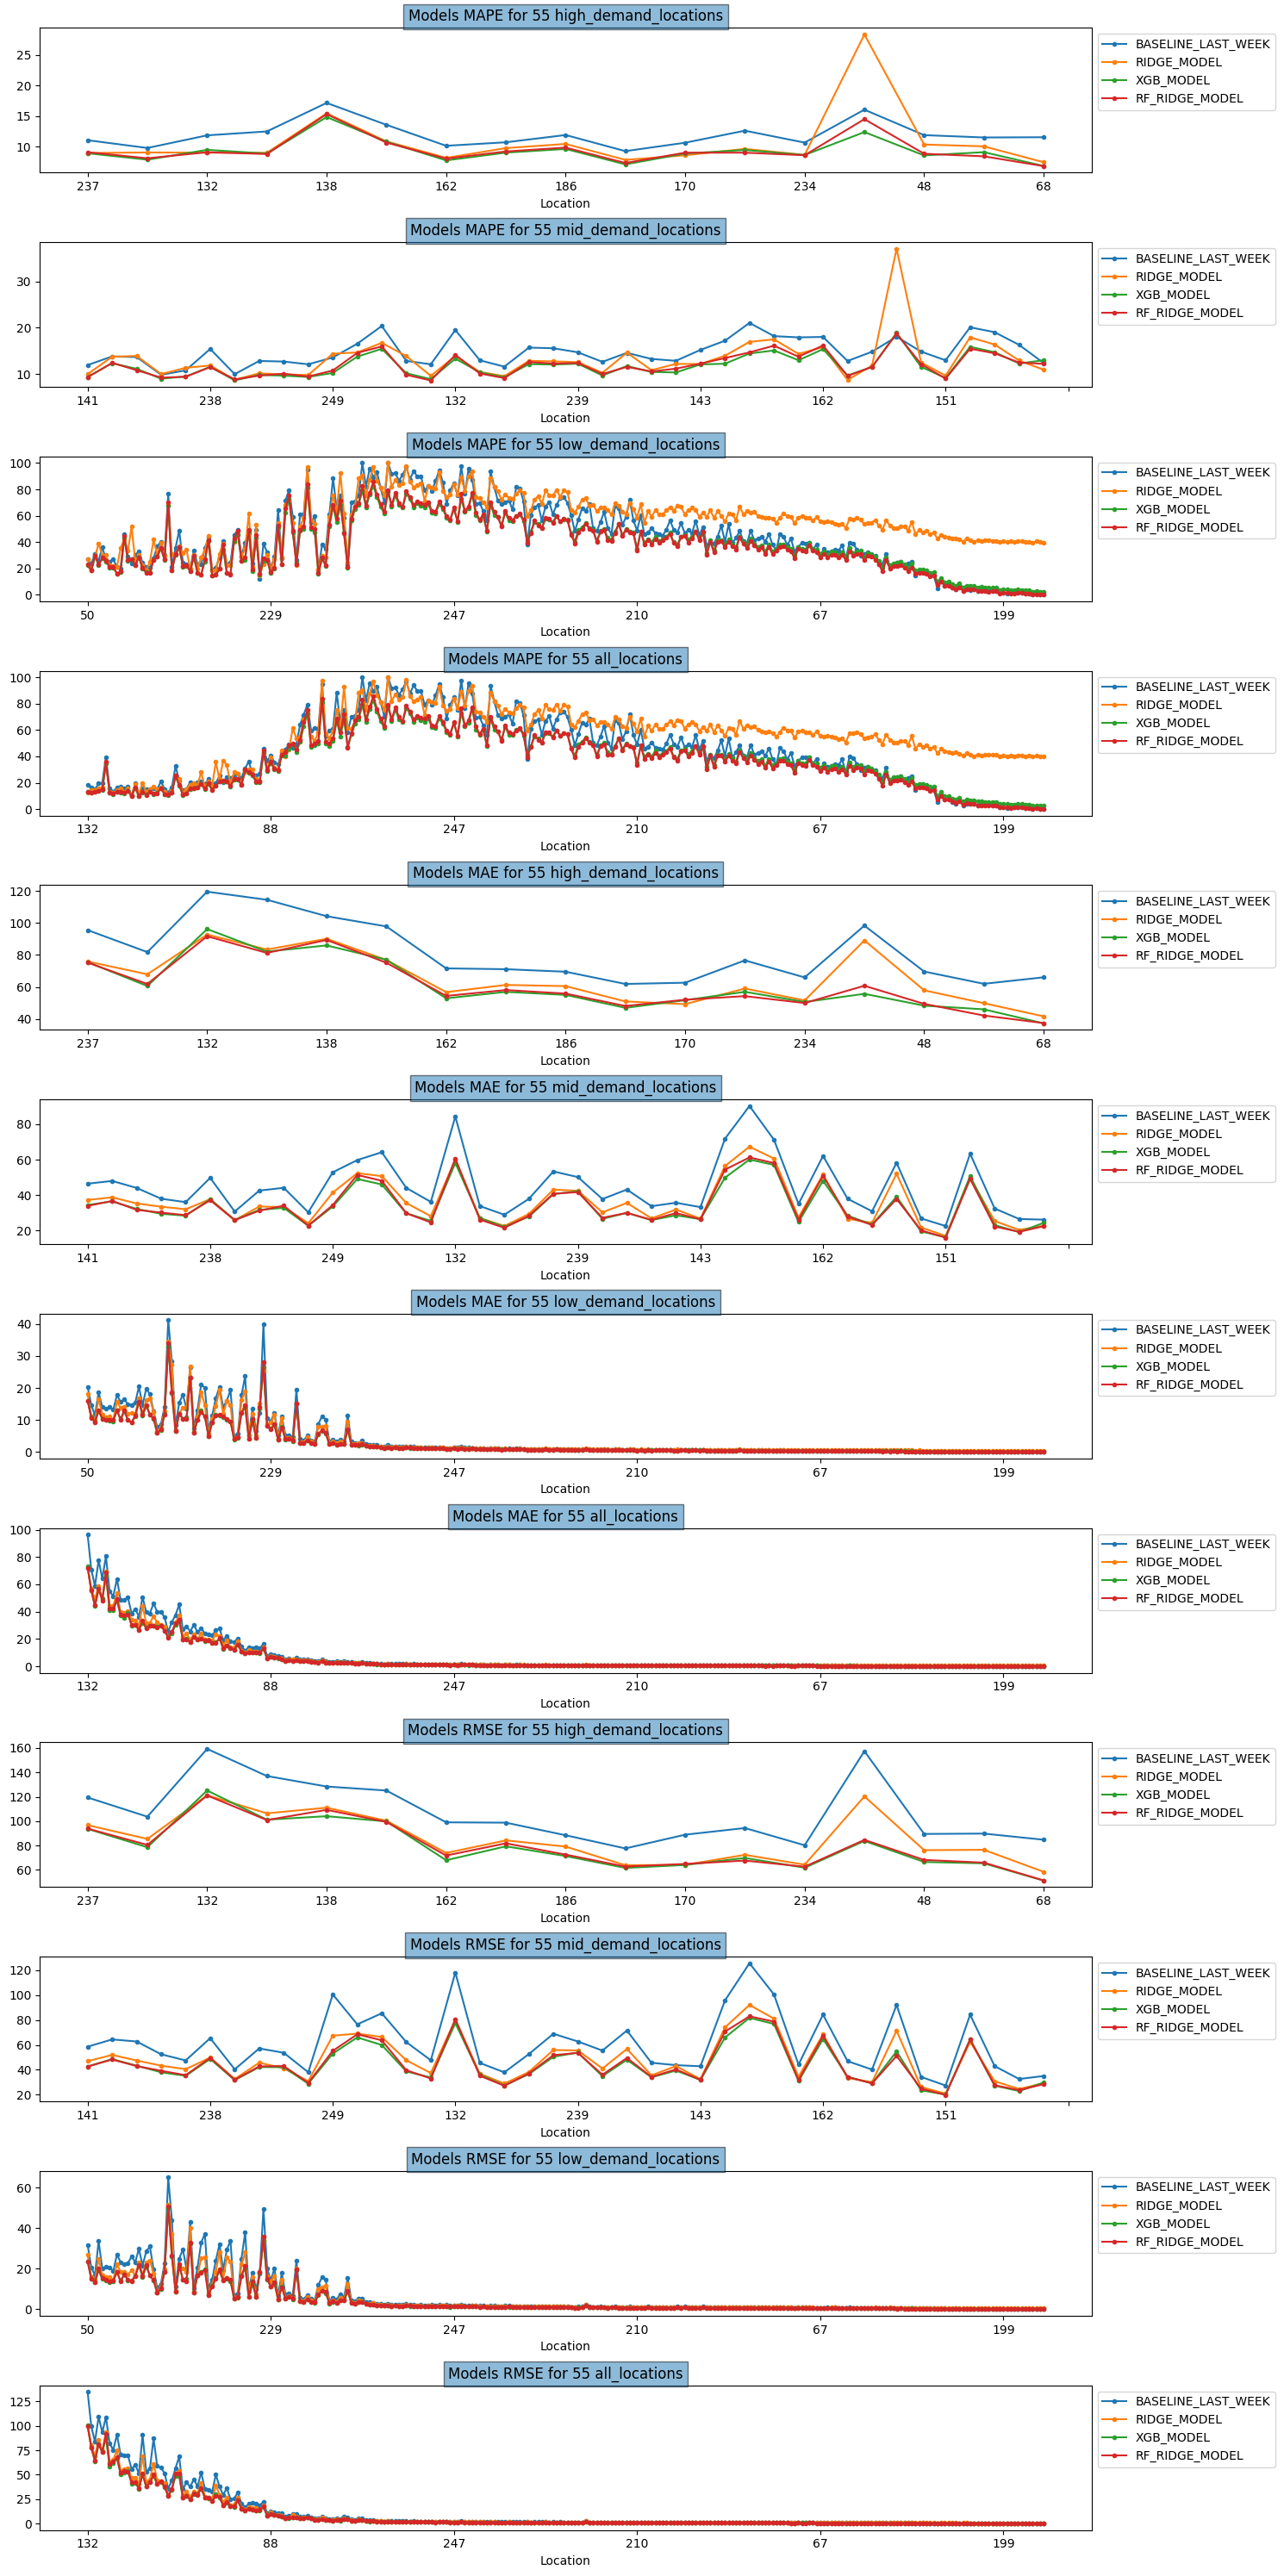

In [18]:
plot(predictions_mean_error_dict, 'Location')

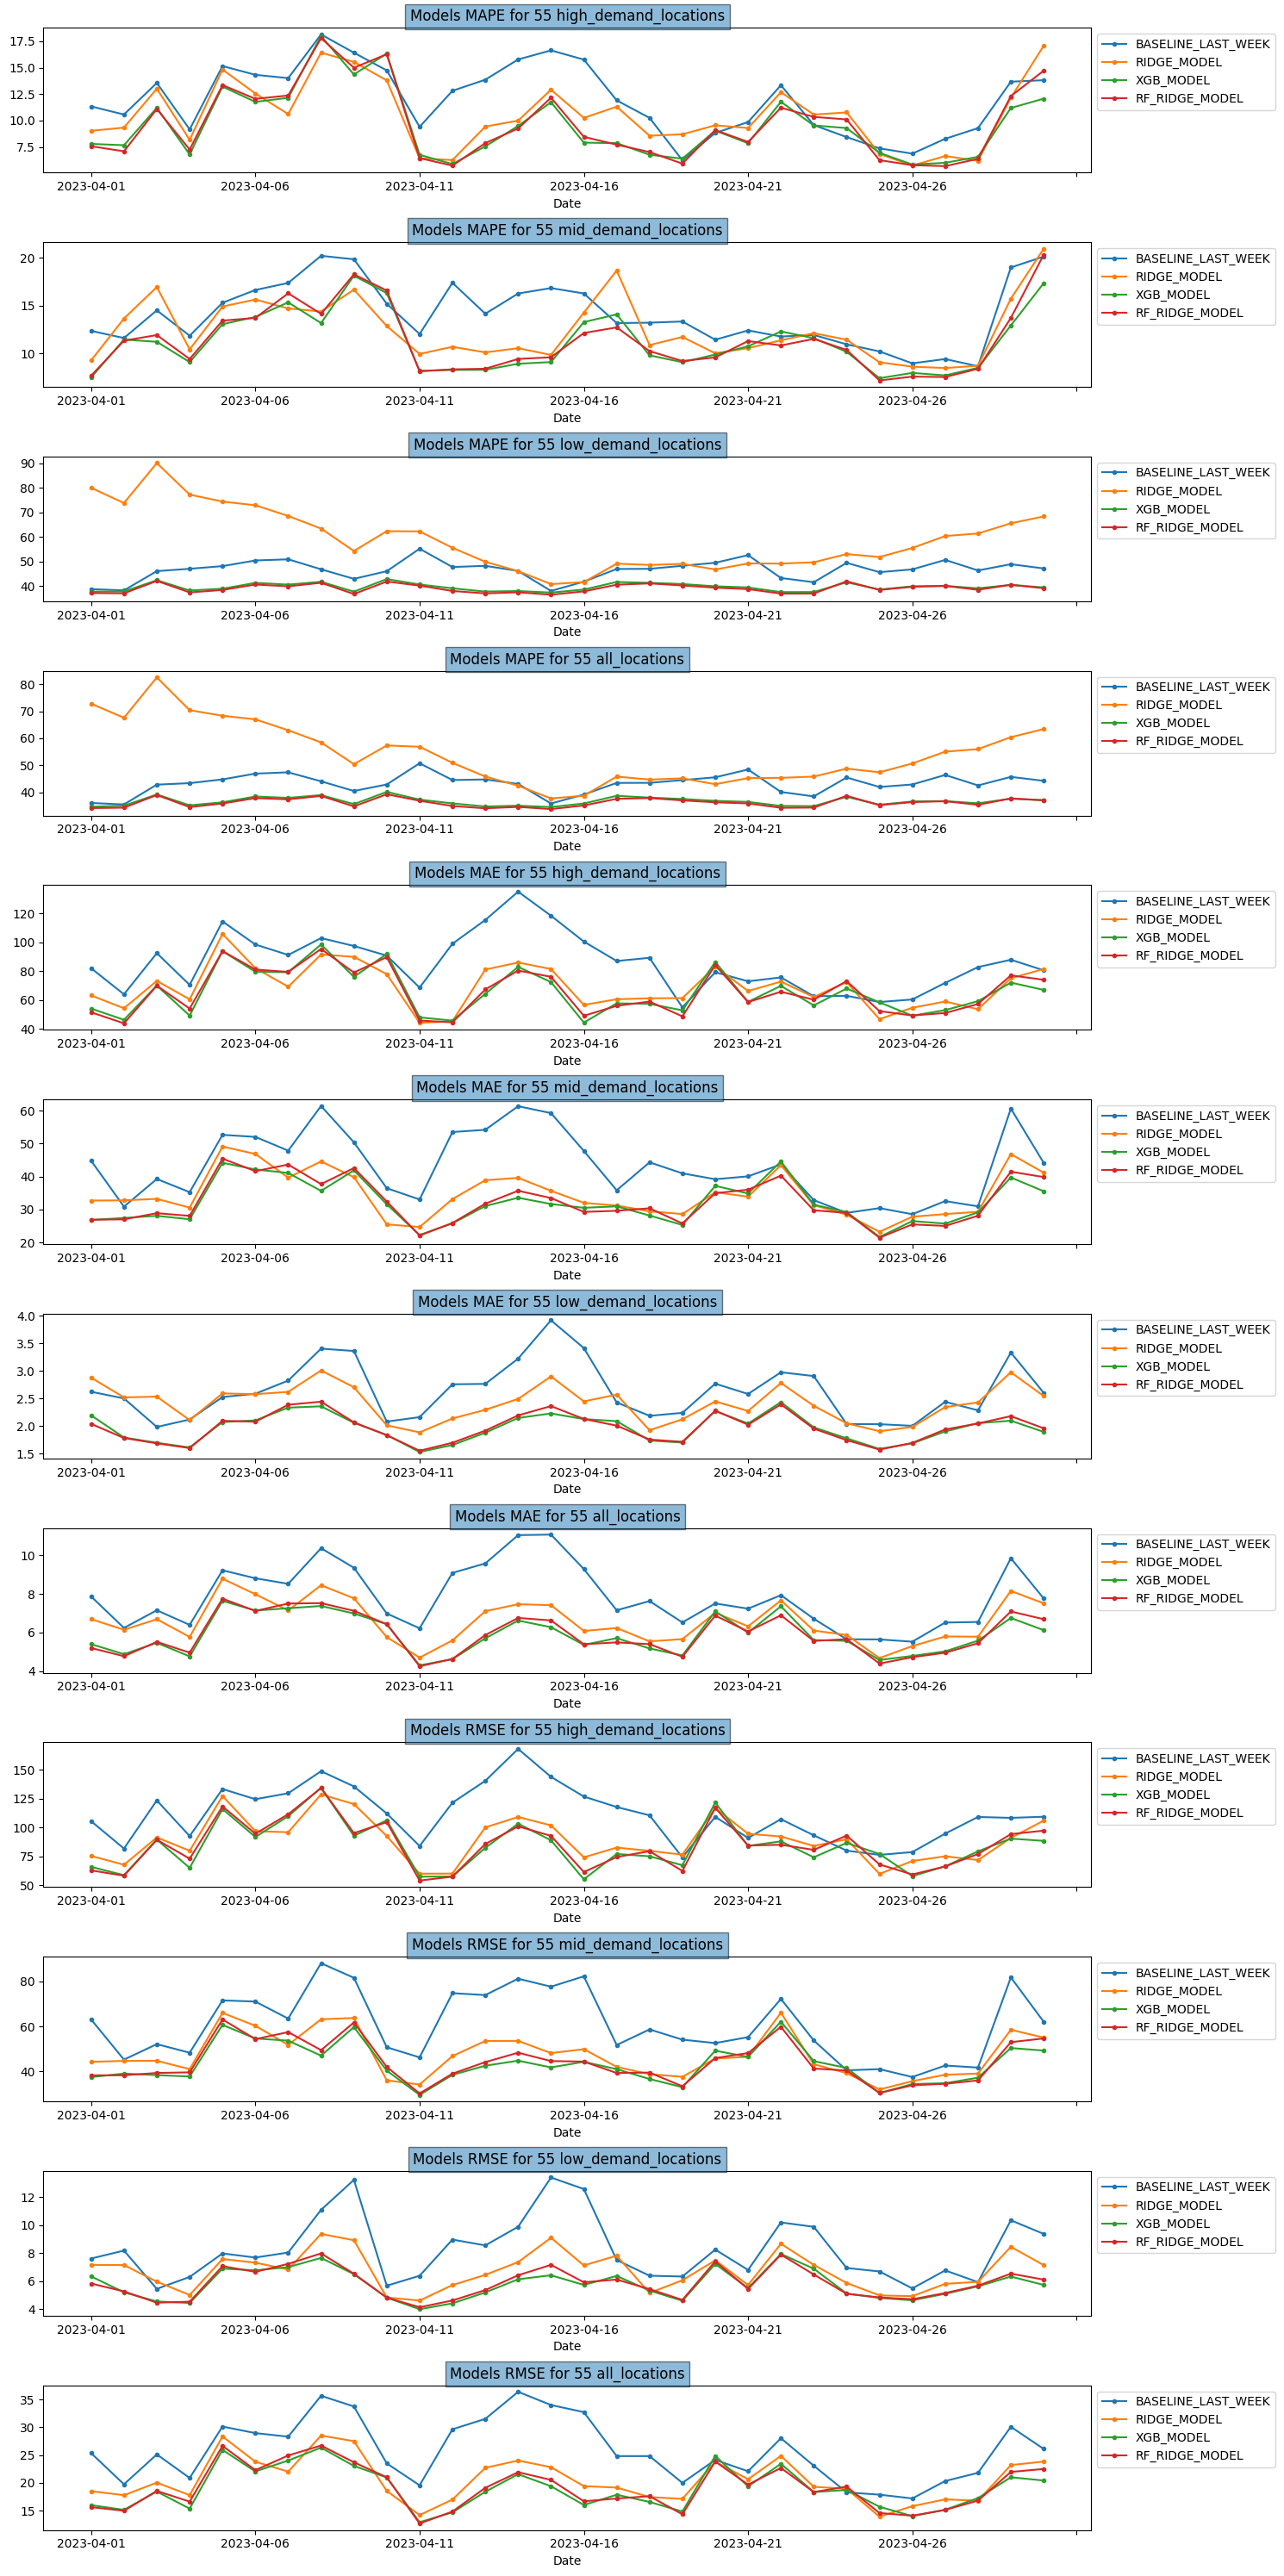

In [19]:
plot(predictions_mean_error_dict, 'Date')

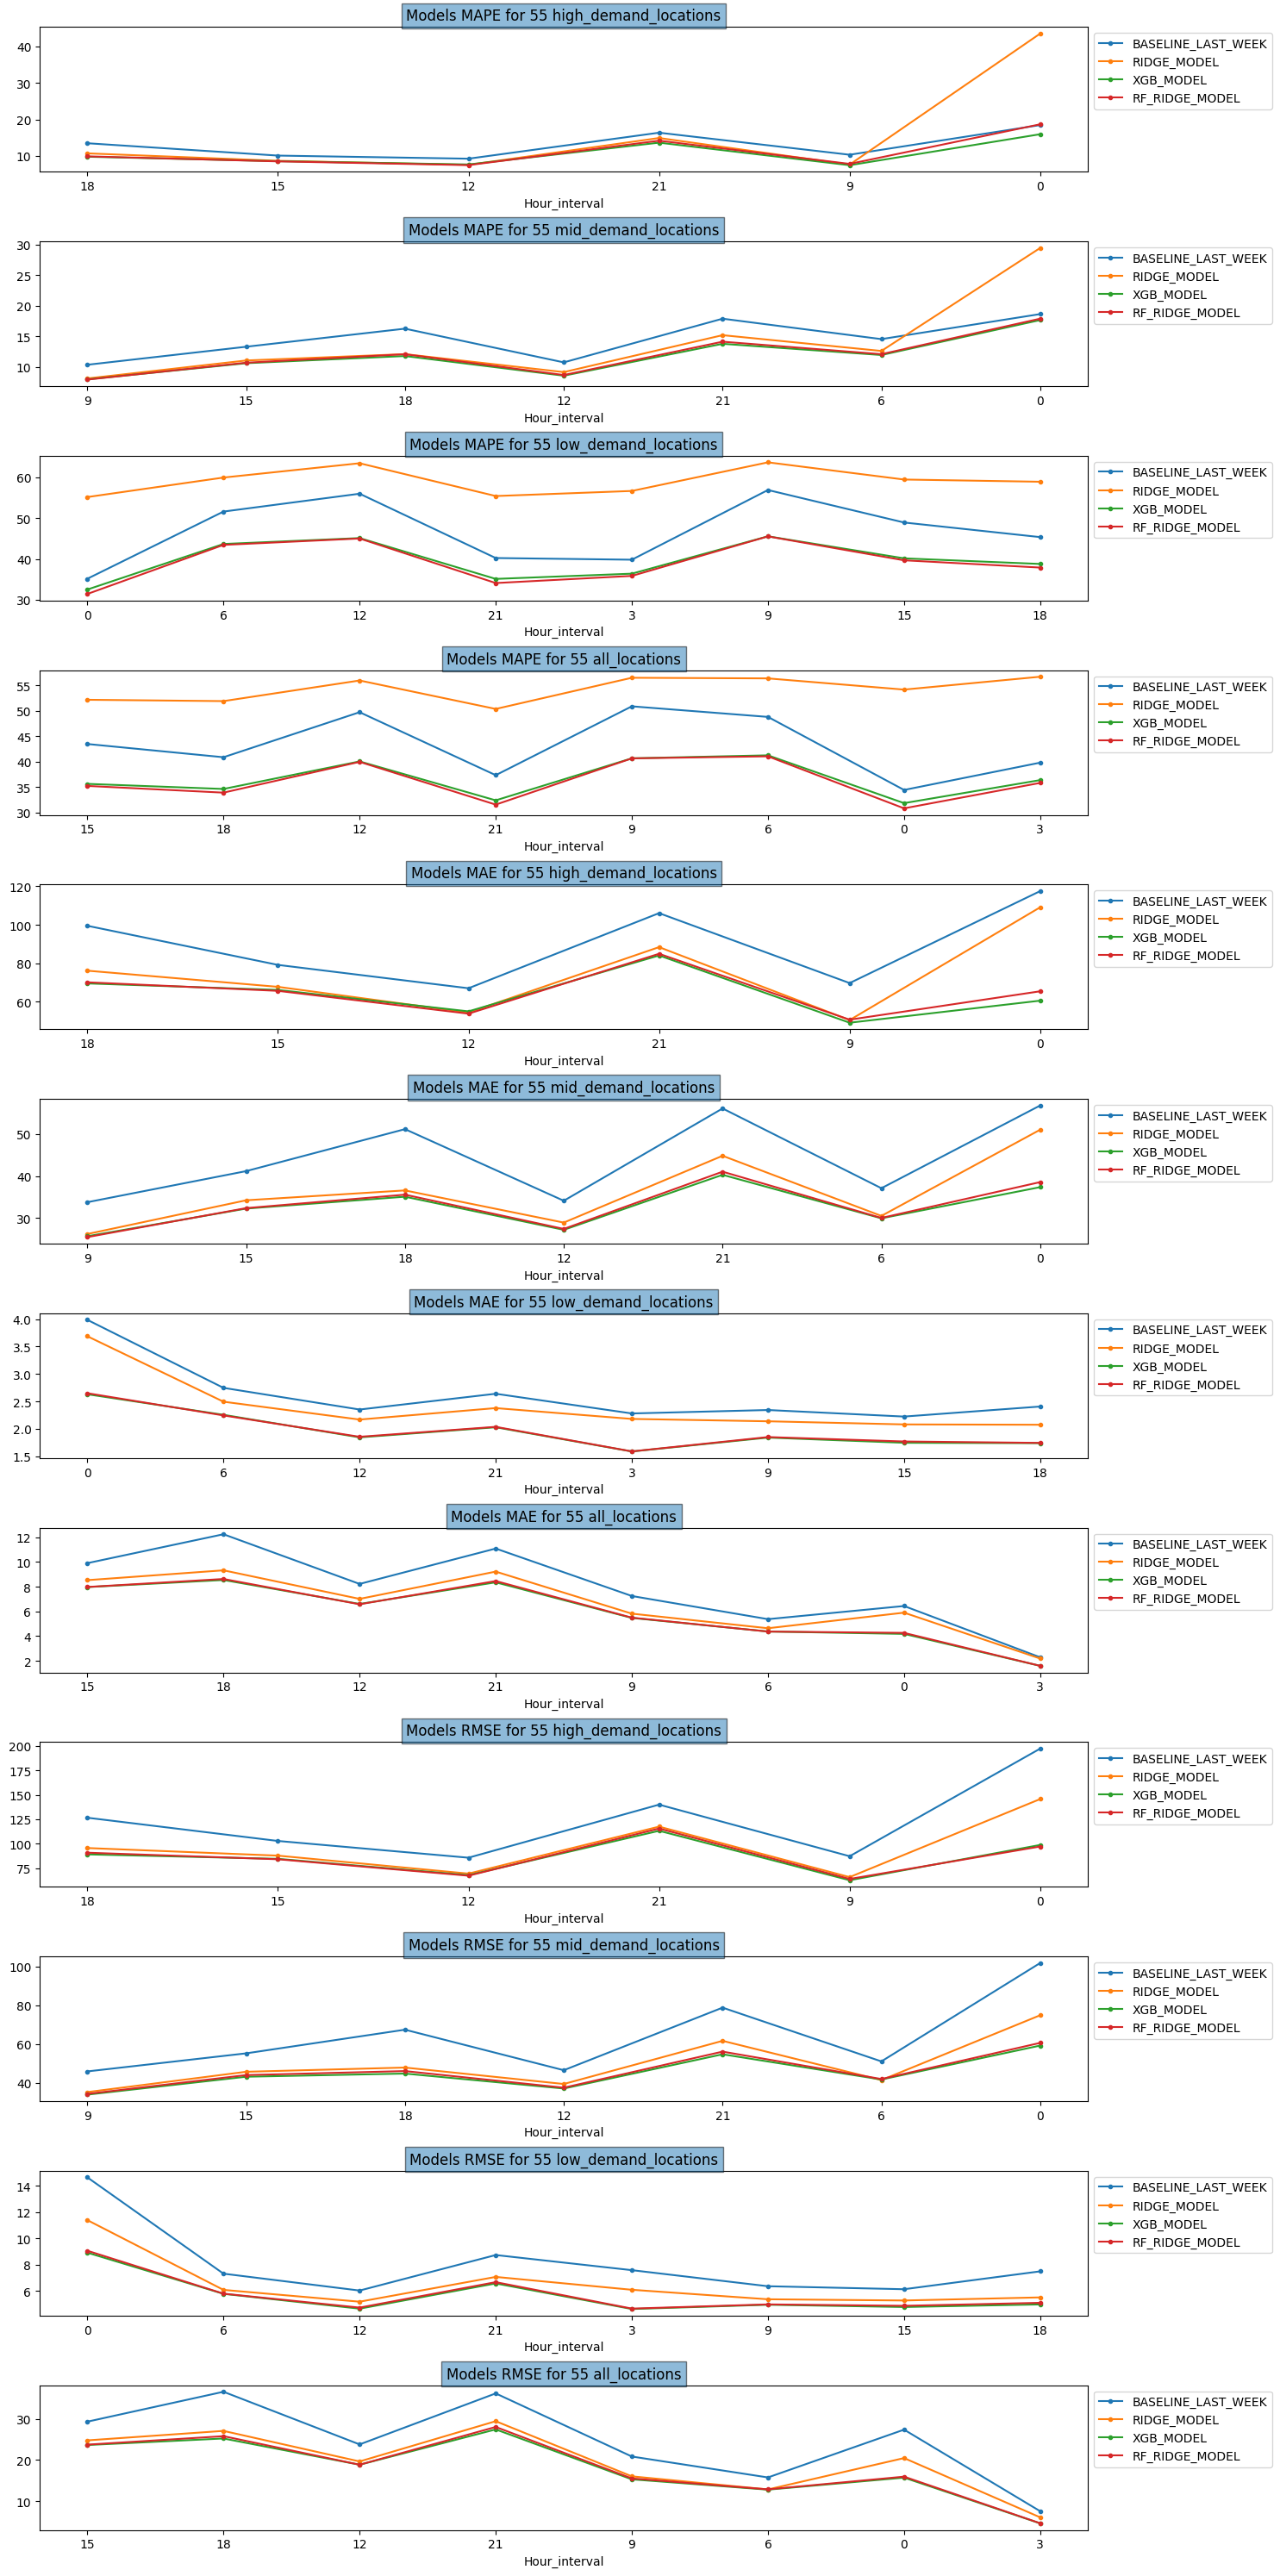

In [20]:
plot(predictions_mean_error_dict, 'Hour_interval')

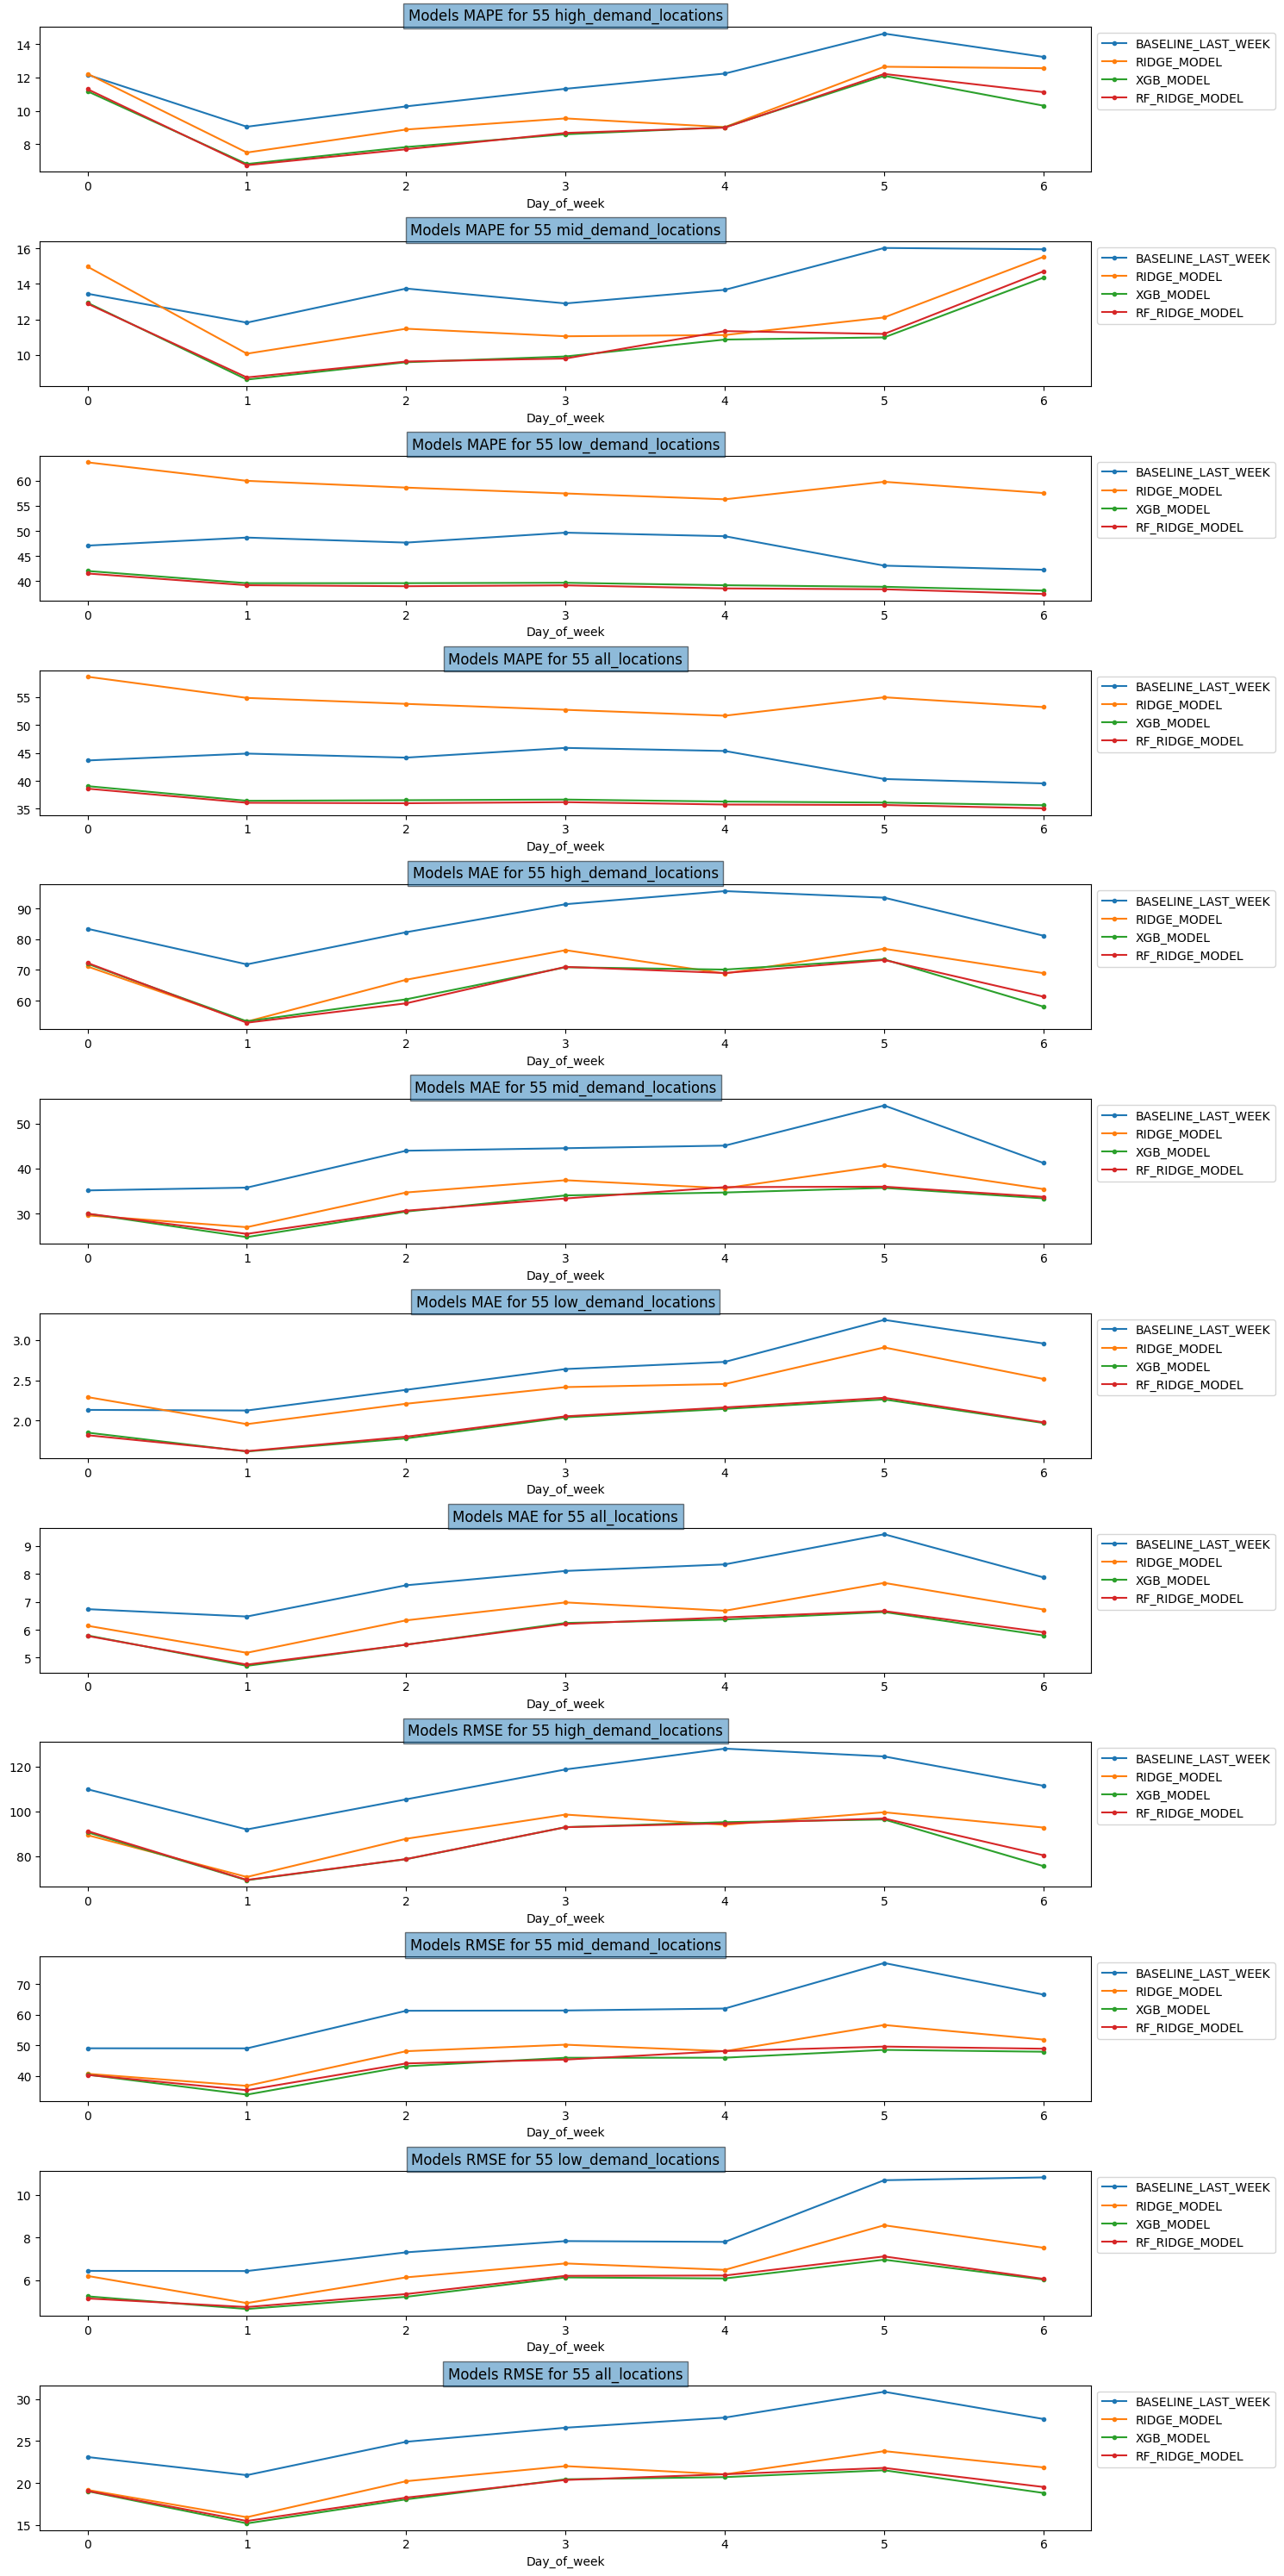

In [21]:
plot(predictions_mean_error_dict, 'Day_of_week')

# Table of Results

In [22]:
def create_table_errors(predictions_dict, report_dict):
    for model, error_df in predictions_dict.items():
        for cat in CATEGORIES:
            if error_df is not None:
                sorted_index = sorted_locations_dict[cat][['Location', 'Hour_interval']]
                categorized_df = error_df.merge(sorted_index, on=['Location','Hour_interval'])
                
                report_dict[cat]['MAE'][model] = categorized_df['error'].mean()            
                report_dict[cat]['RMSE'][model] = np.sqrt(categorized_df['squared_error'].mean())
                report_dict[cat]['MAPE'][model] = categorized_df['percentage_error'].mean()

    return report_dict

In [23]:
report_dict = create_table_errors(predictions_dict, report_dict)
report_df = pd.DataFrame.from_dict({(i,j): report_dict[i][j] 
                            for i in report_dict.keys() 
                            for j in report_dict[i].keys()},
                            orient='index')

report_df.index = pd.MultiIndex.from_tuples(report_df.index)
report_df = report_df.T

In [24]:
df = pd.DataFrame(report_df,
                  index=pd.Index(MODEL_LIST),
                  columns=pd.MultiIndex.from_product([CATEGORIES, METRICS], names=['location CATEGORIES:', 'Error Metrics:']))


In [25]:
df.style.format('{:.2f}')